In [ ]:
!pip install unidecode

# Data Structures
import numpy  as np
import pandas as pd
import json
# Corpus Processing
import re
import nltk
import nltk.corpus
from nltk.tokenize                    import word_tokenize
from nltk                             import SnowballStemmer
from sklearn.feature_extraction.text  import TfidfVectorizer
from sklearn.preprocessing            import normalize
from unidecode import unidecode
# K-Means
from sklearn import cluster

# Visualization and Analysis
import matplotlib.pyplot  as plt
import matplotlib.cm      as cm
import seaborn            as sns
from sklearn.metrics                  import silhouette_samples, silhouette_score
from wordcloud                        import WordCloud


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 235 kB 7.0 MB/s 


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving scraped_pattern_data.csv to scraped_pattern_data.csv


In [ ]:
import pandas as pd
df = pd.read_csv("scraped_pattern_data.csv")
df = df.drop([0, 1, 2, 3])
df = df.drop_duplicates(subset=['name'])

In [ ]:
df['overview'] = df['intent'] + " " + df['problem'] + " " + df['discussion'] + " " + df['structure']
df.head()

,id,category_id,name,intent,problem,discussion,structure,overview
4,6,0,abstract_factory,\nProvide an interface for creating families o...,"If an application is to be portable, it needs ...",Provide a level of indirection that abstracts ...,The Abstract Factory defines a Factory Method ...,\nProvide an interface for creating families o...
5,7,0,adapter,\nConvert the interface of a class into anothe...,"An ""off the shelf"" component offers compelling...",Reuse has always been painful and elusive. On...,"Below, a legacy Rectangle component's display(...",\nConvert the interface of a class into anothe...
6,8,0,prototype,\nSpecify the kinds of objects to create using...,"Application ""hard wires"" the class of object t...",Declare an abstract base class that specifies ...,The Factory knows how to find the correct Prot...,\nSpecify the kinds of objects to create using...
7,9,0,facade,\nProvide a unified interface to a set of inte...,A segment of the client community needs a simp...,Facade discusses encapsulating a complex subsy...,"Facade takes a ""riddle wrapped in an enigma sh...",\nProvide a unified interface to a set of inte...
8,10,0,composite,\nCompose objects into tree structures to repr...,Application needs to manipulate a hierarchical...,Define an abstract base class (Component) that...,"Composites that contain Components, each of wh...",\nCompose objects into tree structures to repr...


In [ ]:
# removes a list of words (ie. stopwords) from a tokenized list.
def removeWords(listOfTokens, listOfWords):
    return [token for token in listOfTokens if token not in listOfWords]

# applies stemming to a list of tokenized words
def applyStemming(listOfTokens, stemmer):
    return [stemmer.stem(token) for token in listOfTokens]

# removes any words composed of less than 2 or more than 21 letters
def twoLetters(listOfTokens):
    twoLetterWord = []
    for token in listOfTokens:
        if len(token) <= 2 or len(token) >= 21:
            twoLetterWord.append(token)
    return twoLetterWord

In [ ]:
nltk.download('stopwords')
def processCorpus(corpus, language):   
    stopwords = nltk.corpus.stopwords.words(language)
    param_stemmer = SnowballStemmer(language)
    
    for document in corpus:
        index = corpus.index(document)
        corpus[index] = str(corpus[index]).replace(u'\ufffd', '8')   # Replaces the ASCII '�' symbol with '8'
        corpus[index] = corpus[index].replace(',', '')          # Removes commas
        corpus[index] = corpus[index].rstrip('\n')              # Removes line breaks
        corpus[index] = corpus[index].casefold()                # Makes all letters lowercase
        
        corpus[index] = re.sub('\W_',' ', corpus[index])        # removes specials characters and leaves only words
        corpus[index] = re.sub("\S*\d\S*"," ", corpus[index])   # removes numbers and words concatenated with numbers IE h4ck3r. Removes road names such as BR-381.
        corpus[index] = re.sub("\S*@\S*\s?"," ", corpus[index]) # removes emails and mentions (words with @)
        corpus[index] = re.sub(r'http\S+', '', corpus[index])   # removes URLs with http
        corpus[index] = re.sub(r'www\S+', '', corpus[index])    # removes URLs with www

        listOfTokens = word_tokenize(corpus[index])
        twoLetterWord = twoLetters(listOfTokens)

        listOfTokens = removeWords(listOfTokens, stopwords)
        listOfTokens = removeWords(listOfTokens, twoLetterWord)
        
        listOfTokens = applyStemming(listOfTokens, param_stemmer)

        corpus[index]   = " ".join(listOfTokens)
        corpus[index] = unidecode(corpus[index])

    return corpus

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
corpus = df['overview'].tolist()
corpus[18][0:447]

"\nDefine the skeleton of an algorithm in an operation, deferring some\nsteps to client subclasses.  Template Method lets subclasses redefine\ncertain steps of an algorithm without changing the algorithm's\nstructure.\nBase class declares algorithm 'placeholders', and derived classes\nimplement the placeholders.\n Two different components have significant similarities, but demonstrate\nno reuse of common interface or implementation.  If a change common"

In [ ]:
import nltk
nltk.download('punkt')

language = 'english'
corpus = processCorpus(corpus, language)
corpus[18][0:460]

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


'defin skeleton algorithm oper defer step client subclass templat method let subclass redefin certain step algorithm without chang algorithm structur base class declar algorithm placehold deriv class implement placehold two differ compon signific similar demonstr reus common interfac implement chang common compon becom necessari duplic effort must expend compon design decid step algorithm invari standard variant customiz invari step implement abstract base '

In [ ]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(corpus)
tf_idf = pd.DataFrame(data = X.toarray(), columns=vectorizer.get_feature_names())

final_df = tf_idf

print("{} rows".format(final_df.shape[0]))
final_df.T.nlargest(5, 0)

26 rows


/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,25
platform,0.486980,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000
factori,0.409175,0.0,0.076320,0.0,0.0,0.085338,0.0,0.000000,0.0,0.512777,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000
famili,0.342961,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000
product,0.255734,0.0,0.076320,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,...,0.0,0.042963,0.000000,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000
concret,0.168793,0.0,0.125935,0.0,0.0,0.000000,0.0,0.032658,0.0,0.000000,...,0.0,0.000000,0.038163,0.0,0.0,0.0,0.0,0.0,0.02191,0.110333


In [ ]:
# first 5 words with highest weight on document 0:
final_df.T.nlargest(5, 0)

,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,25
platform,0.486980,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000
factori,0.409175,0.0,0.076320,0.0,0.0,0.085338,0.0,0.000000,0.0,0.512777,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000
famili,0.342961,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000
product,0.255734,0.0,0.076320,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,...,0.0,0.042963,0.000000,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000
concret,0.168793,0.0,0.125935,0.0,0.0,0.000000,0.0,0.032658,0.0,0.000000,...,0.0,0.000000,0.038163,0.0,0.0,0.0,0.0,0.0,0.02191,0.110333


In [ ]:
def run_KMeans(max_k, data):
    max_k += 1
    kmeans_results = dict()
    for k in range(2 , max_k):
        kmeans = cluster.KMeans(n_clusters = k
                               , init = 'k-means++'
                               , n_init = 10
                               , tol = 0.0001
                               #, n_jobs = -1
                               , random_state = 1
                               , algorithm = 'full')

        kmeans_results.update( {k : kmeans.fit(data)} )
        
    return kmeans_results

In [ ]:
def printAvg(avg_dict):
    for avg in sorted(avg_dict.keys(), reverse=True):
        print("Avg: {}\tK:{}".format(avg.round(4), avg_dict[avg]))
        
def plotSilhouette(df, n_clusters, kmeans_labels, silhouette_avg):
    fig, ax1 = plt.subplots(1)
    fig.set_size_inches(8, 6)
    ax1.set_xlim([-0.2, 1])
    ax1.set_ylim([0, len(df) + (n_clusters + 1) * 10])
    
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--") # The vertical line for average silhouette score of all the values
    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.2, 0, 0.2, 0.4, 0.6, 0.8, 1])
    plt.title(("Silhouette analysis for K = %d" % n_clusters), fontsize=10, fontweight='bold')
    
    y_lower = 10
    sample_silhouette_values = silhouette_samples(df, kmeans_labels) # Compute the silhouette scores for each sample
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[kmeans_labels == i]
        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, facecolor=color, edgecolor=color, alpha=0.7)

        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i)) # Label the silhouette plots with their cluster numbers at the middle
        y_lower = y_upper + 10  # Compute the new y_lower for next plot. 10 for the 0 samples
    plt.show()
    
        
def silhouette(kmeans_dict, df, plot=False):
    df = df.to_numpy()
    avg_dict = dict()
    for n_clusters, kmeans in kmeans_dict.items():      
        kmeans_labels = kmeans.predict(df)
        silhouette_avg = silhouette_score(df, kmeans_labels) # Average Score for all Samples
        avg_dict.update( {silhouette_avg : n_clusters} )
    
        if(plot): plotSilhouette(df, n_clusters, kmeans_labels, silhouette_avg)

/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


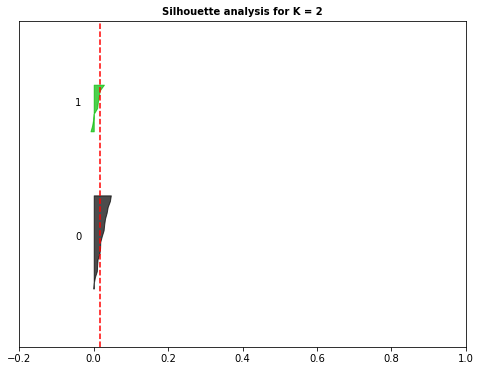

/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


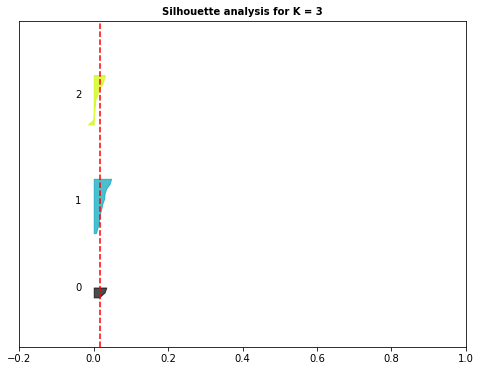

/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


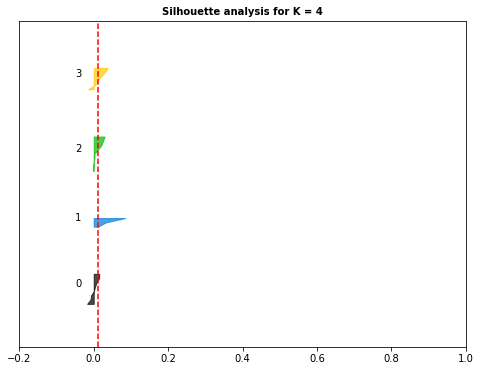

/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


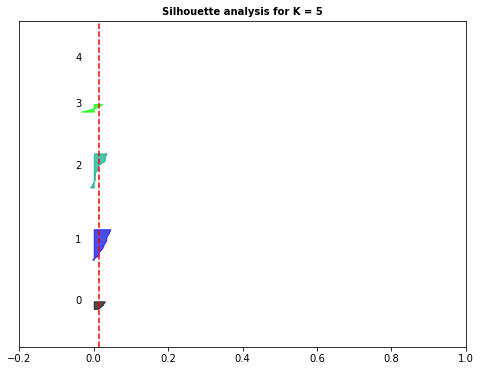

/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


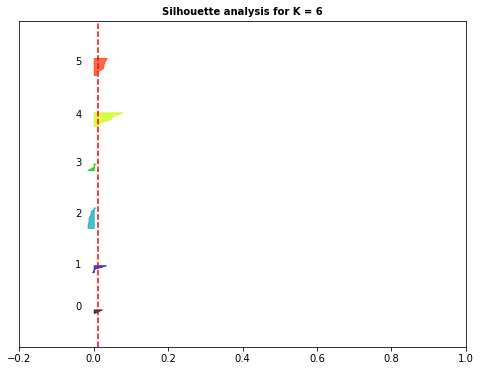

/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


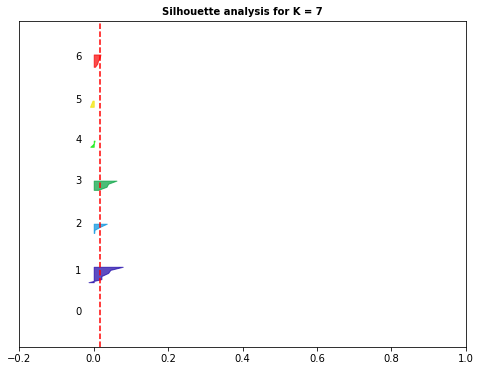

/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


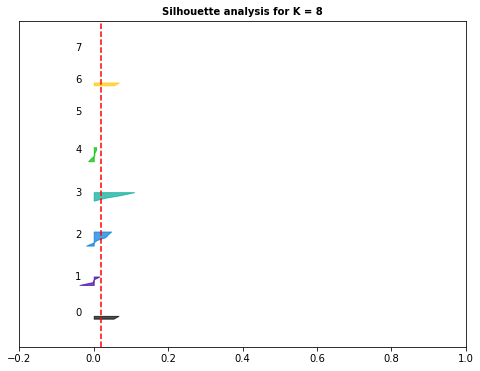

In [ ]:
# Running Kmeans
k = 8
kmeans_results = run_KMeans(k, final_df)

# Plotting Silhouette Analysis
silhouette(kmeans_results, final_df, plot=True)

In [ ]:
def get_top_features_cluster(tf_idf_array, prediction, n_feats):
    labels = np.unique(prediction)
    dfs = []
    for label in labels:
        id_temp = np.where(prediction==label) # indices for each cluster
        x_means = np.mean(tf_idf_array[id_temp], axis = 0) # returns average score across cluster
        sorted_means = np.argsort(x_means)[::-1][:n_feats] # indices with top 20 scores
        features = vectorizer.get_feature_names()
        best_features = [(features[i], x_means[i]) for i in sorted_means]
        df = pd.DataFrame(best_features, columns = ['features', 'score'])
        dfs.append(df)
    return dfs

def plotWords(dfs, n_feats):
    plt.figure(figsize=(8, 4))
    for i in range(0, len(dfs)):
        plt.title(("Most Common Words in Cluster {}".format(i)), fontsize=10, fontweight='bold')
        sns.barplot(x = 'score' , y = 'features', orient = 'h' , data = dfs[i][:n_feats])
        plt.show()

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


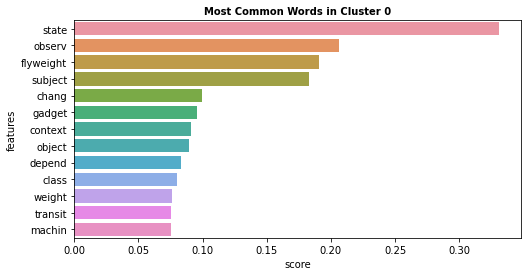

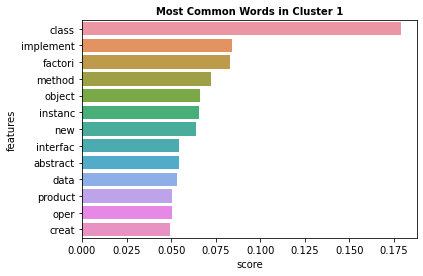

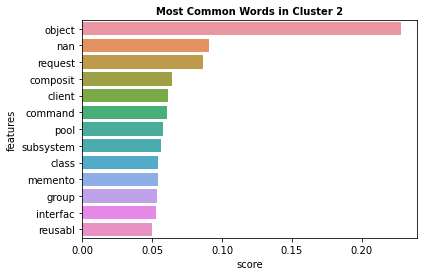

In [ ]:
best_result = 3
kmeans = kmeans_results.get(best_result)

final_df_array = final_df.to_numpy()
prediction = kmeans.predict(final_df)
n_feats = 20
dfs = get_top_features_cluster(final_df_array, prediction, n_feats)
plotWords(dfs, 13)

In [ ]:
# Transforms a centroids dataframe into a dictionary to be used on a WordCloud.
def centroidsDict(centroids, index):
    a = centroids.T[index].sort_values(ascending = False).reset_index().values
    centroid_dict = dict()

    for i in range(0, len(a)):
        centroid_dict.update( {a[i,0] : a[i,1]} )

    return centroid_dict

def generateWordClouds(centroids):
    wordcloud = WordCloud(max_font_size=100, background_color = 'white')
    for i in range(0, len(centroids)):
        centroid_dict = centroidsDict(centroids, i)        
        wordcloud.generate_from_frequencies(centroid_dict)

        plt.figure()
        plt.title('Cluster {}'.format(i))
        plt.imshow(wordcloud)
        plt.axis("off")
        plt.show()

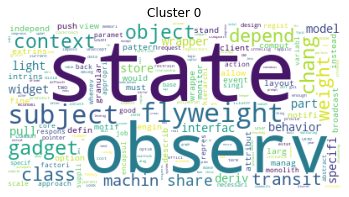

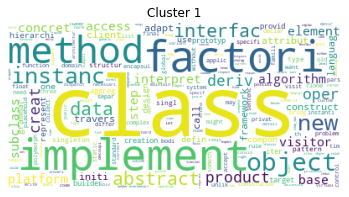

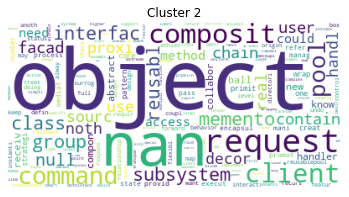

In [ ]:
centroids = pd.DataFrame(kmeans.cluster_centers_)
centroids.columns = final_df.columns
generateWordClouds(centroids)

In [ ]:
# Assigning the cluster labels to each pattern
labels = kmeans.labels_ 
df['label'] = labels
df

,id,category_id,name,intent,problem,discussion,structure,overview,label
4,6,0,abstract_factory,\nProvide an interface for creating families o...,"If an application is to be portable, it needs ...",Provide a level of indirection that abstracts ...,The Abstract Factory defines a Factory Method ...,\nProvide an interface for creating families o...,1
5,7,0,adapter,\nConvert the interface of a class into anothe...,"An ""off the shelf"" component offers compelling...",Reuse has always been painful and elusive. On...,"Below, a legacy Rectangle component's display(...",\nConvert the interface of a class into anothe...,1
6,8,0,prototype,\nSpecify the kinds of objects to create using...,"Application ""hard wires"" the class of object t...",Declare an abstract base class that specifies ...,The Factory knows how to find the correct Prot...,\nSpecify the kinds of objects to create using...,1
7,9,0,facade,\nProvide a unified interface to a set of inte...,A segment of the client community needs a simp...,Facade discusses encapsulating a complex subsy...,"Facade takes a ""riddle wrapped in an enigma sh...",\nProvide a unified interface to a set of inte...,2
8,10,0,composite,\nCompose objects into tree structures to repr...,Application needs to manipulate a hierarchical...,Define an abstract base class (Component) that...,"Composites that contain Components, each of wh...",\nCompose objects into tree structures to repr...,2
9,11,0,flyweight,\nUse sharing to support large numbers of fine...,Designing objects down to the lowest levels of...,The Flyweight pattern describes how to share o...,Flyweights are stored in a Factory's repositor...,\nUse sharing to support large numbers of fine...,0
10,12,0,command,"\nEncapsulate a request as an object, thereby ...",Need to issue requests to objects without know...,Command decouples the object that invokes the ...,The client that creates a command is not the s...,"\nEncapsulate a request as an object, thereby ...",2
11,13,0,interpreter,"\nGiven a language, define a representation fo...",A class of problems occurs repeatedly in a wel...,The Interpreter pattern discusses: defining a ...,Interpreter suggests modeling the domain with ...,"\nGiven a language, define a representation fo...",1
12,14,0,memento,"\nWithout violating encapsulation, capture and...",Need to restore an object back to its previous...,The client requests a Memento from the source ...,\n\n,"\nWithout violating encapsulation, capture and...",2
13,15,0,factory_method,"\nDefine an interface for creating an object, ...",A framework needs to standardize the architect...,Factory Method is to creating objects as Templ...,The implementation of Factory Method discussed...,"\nDefine an interface for creating an object, ...",1


In [ ]:
print("Cluster centroids: \n")
order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()
tempk = 3
for i in range(tempk):
  print("Cluster %d:" % i)
  for j in order_centroids[i, :10]: #print out 10 features terms of each cluster
    print('%s'% terms[j])
  print('------------------')

Cluster centroids: 

Cluster 0:
state
observ
flyweight
subject
chang
gadget
context
object
depend
class
------------------
Cluster 1:
class
implement
factori
method
object
instanc
new
interfac
abstract
data
------------------
Cluster 2:
object
nan
request
composit
client
command
pool
subsystem
class
memento
------------------


/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
!pip install fuzzy-c-means
from fcmeans import FCM

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Attempting uninstall: typer
    Found existing installation: typer 0.7.0
    Uninstalling typer-0.7.0:
      Successfully uninstalled typer-0.7.0


In [ ]:
my_model = FCM(n_clusters=3) # we use three cluster as an example
my_model.fit(final_df_array) ## X, numpy array. rows:samples columns:features
centers = my_model.centers
fuzzLabels = my_model.predict(final_df_array)

df['fuzzLabels'] = fuzzLabels
df

,id,category_id,name,intent,problem,discussion,structure,overview,label,fuzzLabels
4,6,0,abstract_factory,\nProvide an interface for creating families o...,"If an application is to be portable, it needs ...",Provide a level of indirection that abstracts ...,The Abstract Factory defines a Factory Method ...,\nProvide an interface for creating families o...,1,2
5,7,0,adapter,\nConvert the interface of a class into anothe...,"An ""off the shelf"" component offers compelling...",Reuse has always been painful and elusive. On...,"Below, a legacy Rectangle component's display(...",\nConvert the interface of a class into anothe...,1,1
6,8,0,prototype,\nSpecify the kinds of objects to create using...,"Application ""hard wires"" the class of object t...",Declare an abstract base class that specifies ...,The Factory knows how to find the correct Prot...,\nSpecify the kinds of objects to create using...,1,2
7,9,0,facade,\nProvide a unified interface to a set of inte...,A segment of the client community needs a simp...,Facade discusses encapsulating a complex subsy...,"Facade takes a ""riddle wrapped in an enigma sh...",\nProvide a unified interface to a set of inte...,2,0
8,10,0,composite,\nCompose objects into tree structures to repr...,Application needs to manipulate a hierarchical...,Define an abstract base class (Component) that...,"Composites that contain Components, each of wh...",\nCompose objects into tree structures to repr...,2,0
9,11,0,flyweight,\nUse sharing to support large numbers of fine...,Designing objects down to the lowest levels of...,The Flyweight pattern describes how to share o...,Flyweights are stored in a Factory's repositor...,\nUse sharing to support large numbers of fine...,0,0
10,12,0,command,"\nEncapsulate a request as an object, thereby ...",Need to issue requests to objects without know...,Command decouples the object that invokes the ...,The client that creates a command is not the s...,"\nEncapsulate a request as an object, thereby ...",2,0
11,13,0,interpreter,"\nGiven a language, define a representation fo...",A class of problems occurs repeatedly in a wel...,The Interpreter pattern discusses: defining a ...,Interpreter suggests modeling the domain with ...,"\nGiven a language, define a representation fo...",1,1
12,14,0,memento,"\nWithout violating encapsulation, capture and...",Need to restore an object back to its previous...,The client requests a Memento from the source ...,\n\n,"\nWithout violating encapsulation, capture and...",2,0
13,15,0,factory_method,"\nDefine an interface for creating an object, ...",A framework needs to standardize the architect...,Factory Method is to creating objects as Templ...,The implementation of Factory Method discussed...,"\nDefine an interface for creating an object, ...",1,2


In [ ]:
# initialize test data
data = ["Design a drawing editor. A design is composed of te graphics (lines, rectangles and roses), positioned at precise positions. Each graphic form must be modeled by a class that provides a method draw(): void. A rose is a complex graphic designed by a black-box class component. This component performs this drawing in memory, and provides access through a method getRose(): int that returns the address of the drawing. It is probable that the system evolves in order to draw circles."]

# Create test data frame
#dfTest = pd.DataFrame(data, columns=['TestDesignProblem'])
#corpusTest = dfTest['TestDesignProblem'].tolist()
#corpusTest[0][0:447]

# Append the problem to the existing data frame of patterns, with the problem statement written to the 'overview' column and the other columns left blank
new_row = {'category_id':0, 'name':'design_problem', 'intent':'', 'problem':'', 'discussion':'', 'structure':'', 'overview':data[0]}
#append row to the dataframe
dfTest = df.append(new_row, ignore_index=True)
corpusTest = dfTest['overview'].tolist()
corpusTest[26][0:447]

'Design a drawing editor. A design is composed of te graphics (lines, rectangles and roses), positioned at precise positions. Each graphic form must be modeled by a class that provides a method draw(): void. A rose is a complex graphic designed by a black-box class component. This component performs this drawing in memory, and provides access through a method getRose(): int that returns the address of the drawing. It is probable that the system'

In [ ]:
corpusTest = processCorpus(corpusTest, language)
corpusTest[26][0:460]

'design draw editor design compos graphic line rectangl rose posit precis posit graphic form must model class provid method draw void rose complex graphic design black-box class compon compon perform draw memori provid access method getros int return address draw probabl system evolv order draw circl'

In [ ]:
vectorizer_test = TfidfVectorizer()
X_test = vectorizer_test.fit_transform(corpusTest)
tf_idf_test = pd.DataFrame(data = X_test.toarray(), columns=vectorizer_test.get_feature_names())

final_df_test = tf_idf_test

print("{} rows".format(final_df_test.shape[0]))
final_df_test.T.nlargest(5, 0)

27 rows


/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,0,1,2,3,4,5,6,7,8,9,...,17,18,19,20,21,22,23,24,25,26
platform,0.486857,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
factori,0.409946,0.0,0.076434,0.0,0.0,0.085547,0.0,0.000000,0.0,0.514635,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
famili,0.342440,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
product,0.256216,0.0,0.076434,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,...,0.043028,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
concret,0.169591,0.0,0.126479,0.0,0.0,0.000000,0.0,0.032824,0.0,0.000000,...,0.000000,0.038407,0.0,0.0,0.0,0.0,0.0,0.021976,0.110904,0.0


In [ ]:
# do we need to make a new kmeans? (to account for the new features added by the design problem)


#labelTest = kmeans.predict(final_df_test) # predict the result for the design problem alone based on the existing clusters
#labelTest

my_model = FCM(n_clusters=3) # we use three clusters as an example
my_model.fit(final_df_test.to_numpy()) # parameter: numpy array. rows:samples columns:features
centers = my_model.centers
fuzzLabels = my_model.predict(final_df_test.to_numpy())

dfTest['fuzzLabels'] = fuzzLabels
dfTest

,id,category_id,name,intent,problem,discussion,structure,overview,label,fuzzLabels
0,6.0,0,abstract_factory,\nProvide an interface for creating families o...,"If an application is to be portable, it needs ...",Provide a level of indirection that abstracts ...,The Abstract Factory defines a Factory Method ...,\nProvide an interface for creating families o...,1.0,2
1,7.0,0,adapter,\nConvert the interface of a class into anothe...,"An ""off the shelf"" component offers compelling...",Reuse has always been painful and elusive. On...,"Below, a legacy Rectangle component's display(...",\nConvert the interface of a class into anothe...,1.0,2
2,8.0,0,prototype,\nSpecify the kinds of objects to create using...,"Application ""hard wires"" the class of object t...",Declare an abstract base class that specifies ...,The Factory knows how to find the correct Prot...,\nSpecify the kinds of objects to create using...,1.0,2
3,9.0,0,facade,\nProvide a unified interface to a set of inte...,A segment of the client community needs a simp...,Facade discusses encapsulating a complex subsy...,"Facade takes a ""riddle wrapped in an enigma sh...",\nProvide a unified interface to a set of inte...,2.0,2
4,10.0,0,composite,\nCompose objects into tree structures to repr...,Application needs to manipulate a hierarchical...,Define an abstract base class (Component) that...,"Composites that contain Components, each of wh...",\nCompose objects into tree structures to repr...,2.0,1
5,11.0,0,flyweight,\nUse sharing to support large numbers of fine...,Designing objects down to the lowest levels of...,The Flyweight pattern describes how to share o...,Flyweights are stored in a Factory's repositor...,\nUse sharing to support large numbers of fine...,0.0,0
6,12.0,0,command,"\nEncapsulate a request as an object, thereby ...",Need to issue requests to objects without know...,Command decouples the object that invokes the ...,The client that creates a command is not the s...,"\nEncapsulate a request as an object, thereby ...",2.0,1
7,13.0,0,interpreter,"\nGiven a language, define a representation fo...",A class of problems occurs repeatedly in a wel...,The Interpreter pattern discusses: defining a ...,Interpreter suggests modeling the domain with ...,"\nGiven a language, define a representation fo...",1.0,0
8,14.0,0,memento,"\nWithout violating encapsulation, capture and...",Need to restore an object back to its previous...,The client requests a Memento from the source ...,\n\n,"\nWithout violating encapsulation, capture and...",2.0,1
9,15.0,0,factory_method,"\nDefine an interface for creating an object, ...",A framework needs to standardize the architect...,Factory Method is to creating objects as Templ...,The implementation of Factory Method discussed...,"\nDefine an interface for creating an object, ...",1.0,2
